# CSPB 3022 Project

## Author: Adam Fowler
***

## Project Topic

This project explores a dataset with various attributes of a person in order to determine if they are likely to get a job that pays $50k or more using binary classification. While this is primarily a classification exercise, if regression is applicable I would like to apply that as well.

The goal of this project is to be able to correctly classify these instances. My motivation is simply to learn the techniques involved.

This project and related files will be stored at [https://github.com/cockytrumpet/classification_project](https://github.com/cockytrumpet/classification_project)

## Data

The dataset used is available from [Kaggle](https://www.kaggle.com/datasets/galshochat/classification-problem-yes-or-no-50k-salary). No information is given on how the data was gathered.

>Gal Shochat. (2022). Classification problem/ Yes or NO 50K salary, Version 1. Retrieved April 5, 2023 from https://www.kaggle.com/datasets/galshochat/classification-problem-yes-or-no-50k-salary.

In [83]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model,metrics,neighbors,model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [84]:
df = pd.read_csv('adult.data');
print(f'{df.shape = }')
df.head()

df.shape = (32560, 15)


,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


The data is tabulated with 32560 samples and 15 features. 

| Feature | Type |
|-|-|
| Age | Integer |
| Workclass | Category |
| fnwlgt | Integer |
| Education | Name of education level |
| Education-year | Numerical education level |
| Marital-Status | Category |
| Occupation | Category |
| Relationship | Category |
| Race | Category |
| Sex | Boolean |
| Capital-gain | Integer |
| Capital-loss | Integer |
| Hours-per-week | Integer |
| Native_country | Category |
| Salary | Binary (for prediciton >=$50k) |

## Data Cleaning

The data doesn't have a header, but the variables are listed on Kaggle. I'll add them here.

In [85]:
columns = [ 'Age', 'Workclass' , 'fnlwgt', 'Education', 'Education-year', 'Marital-Status', 
            'Occupation', 'Relationship', 'Race', 'Sex' , 'Capital-gain', 
            'Capital-loss', 'Hours-per-week', 'Native_country', 'Salary']

df.columns = columns
df.head()

,Age,Workclass,fnlwgt,Education,Education-year,Marital-Status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native_country,Salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


There don't appear to be any missing values to deal with.

In [86]:
df.isnull().sum()

Age               0
Workclass         0
fnlwgt            0
Education         0
Education-year    0
Marital-Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital-gain      0
Capital-loss      0
Hours-per-week    0
Native_country    0
Salary            0
dtype: int64

The *Education* and *Education-year* features are redundant. The year seems like it will be easier to work with, so I will drop the other. The variable *fnlwgt* is a census metric that only has meaning when comparing people from the same state, so I'm going to drop that as well as variables that I don't intend to use.

In [87]:
df.drop(['fnlwgt','Capital-gain','Capital-loss','Relationship',
         'Native_country', 'Education'], axis=1, inplace=True)
df.rename(columns={'Education-year': 'Education'}, inplace=True)

The target variable *Salary* will be easier to work with if it's not a string, so I'm going to convert it to binary.

In [88]:
df['Salary'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [89]:
df['50k'] = np.nan
df.loc[df['Salary'].str.contains('<'), '50k'] = 0
df.loc[df['Salary'].str.contains('>'), '50k'] = 1
df = df.astype({'50k': int})
df = df.drop(['Salary'], axis=1)
df['50k'].unique()

array([0, 1])

The categorical variables have extra whitespace throughout. I'm going to remove it.

In [90]:
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.strip()

## EDA (and more cleaning)

Of the different *workclasses* available, it seems to make sense to limit the analysis to the private sector jobs.

In [69]:
df['Workclass'].unique()

array(['Self-emp-not-inc', 'Private', 'State-gov', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [70]:
private = df.loc[df['Workclass'] == 'Private']
private = private.drop(['Workclass'], axis=1)
positive = private.loc[private['50k'] == 1]
negative = private.loc[private['50k'] == 0]
print(f'{positive.shape = }')
print(f'{negative.shape = }')

positive.shape = (4963, 8)
negative.shape = (17733, 8)


These is a class imbalance. I attempted both undersampling and oversampling. Oversampling produced better results.

In [91]:
# oversample for class imbalance
positive_size = positive.shape[0]
negative_size = negative.shape[0]

positive_sample = positive.sample(n=negative_size-positive_size, 
                                  replace=True, random_state=1)
data = pd.concat([positive,positive_sample,negative], ignore_index=True)

The dataset now contains an equal number of samples <$50k and >$50k.

In [14]:
data.describe()

,Age,Education,Hours-per-week,50k
count,35466.000000,35466.000000,35466.000000,35466.000000
mean,38.998477,10.443213,42.161112,0.500000
std,12.211545,2.531617,11.075295,0.500007
min,17.000000,1.000000,1.000000,0.000000
25%,30.000000,9.000000,40.000000,0.000000
50%,38.000000,10.000000,40.000000,0.500000
75%,47.000000,13.000000,48.000000,1.000000
max,90.000000,16.000000,99.000000,1.000000


### Distribution of numeric variables

I will plot the frequencies of the numeric variables to get a sense of their distribution. I use a combination of private sector, private sector >$50k, and private sector <$50k sets.

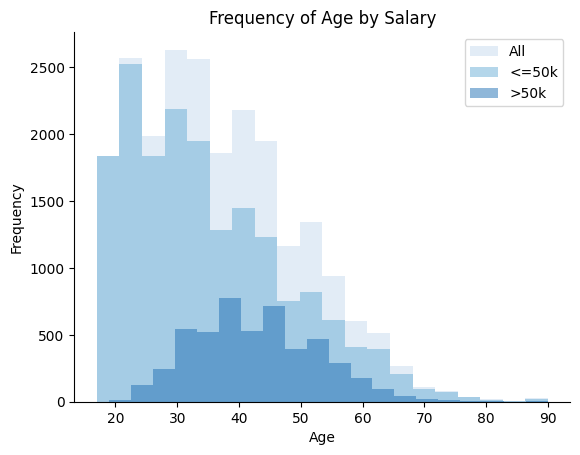

In [15]:
sns.set_palette('Blues', 3)
plt.hist(private['Age'], bins=20 ,alpha=0.5, label='All')
plt.hist(negative['Age'], bins=20, alpha=0.5, label='<=50k')
plt.hist(positive['Age'], bins=20, alpha=0.5, label='>50k')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Frequency of Age by Salary')
plt.legend(loc='upper right')
sns.despine()
plt.show()

There is heavy scew in the overall data and <=50k group. This makes sense as it seems unlikely for an 18 year old with no college to be making more than $50k/year. The > $50k/year group seems more normally distributed. There is considerable overlap between the two groups, so this variable may have limited predictive value.

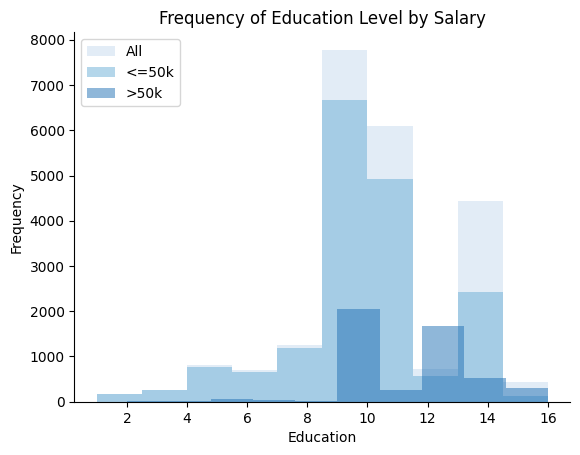

In [16]:
plt.hist(private['Education'], alpha=0.5, label='All')
plt.hist(negative['Education'], alpha=0.5, label='<=50k')
plt.hist(positive['Education'], alpha=0.5, label='>50k')
plt.xlabel('Education')
plt.ylabel('Frequency')
plt.title('Frequency of Education Level by Salary')
plt.legend(loc='upper left')
sns.despine()
plt.show()

On this scale, *9* indicates a high-school graduate while a *13* indicates a bachelors degree. This variable appears to be a strong indicator for the target variable. Very few in the >50k group are below *9*.



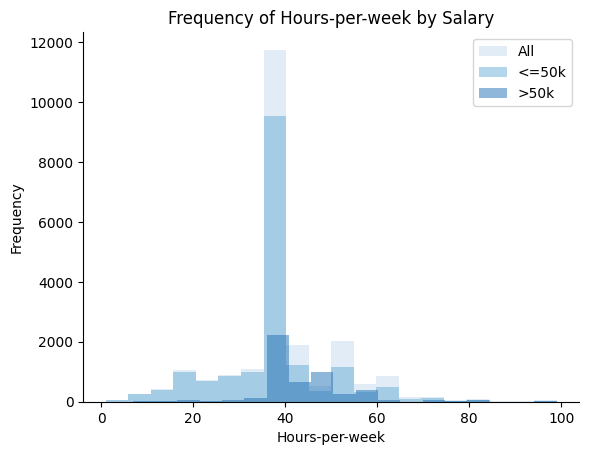

In [17]:
plt.hist(private['Hours-per-week'], bins=20, alpha=0.5, label='All')
plt.hist(negative['Hours-per-week'], bins=20, alpha=0.5, label='<=50k')
plt.hist(positive['Hours-per-week'], bins=20, alpha=0.5, label='>50k')
plt.xlabel('Hours-per-week')
plt.ylabel('Frequency')
plt.title('Frequency of Hours-per-week by Salary')
plt.legend(loc='upper right')
sns.despine()
plt.show()

The 40-hour work week is well represented in both groups. This variable might also have predictive value as very few in the >50k group work less than 40 hours/week.

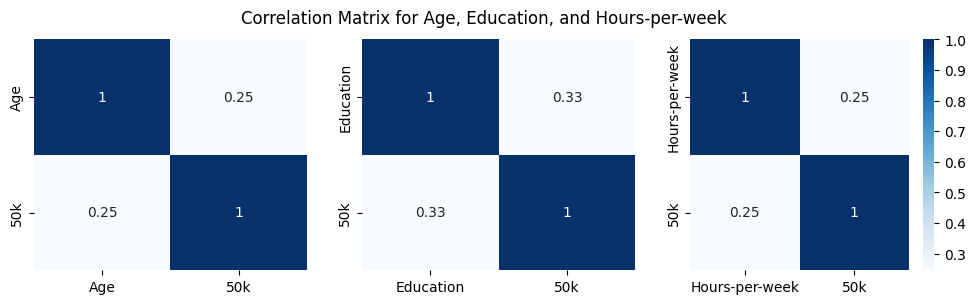

In [18]:
age = private[['Age', '50k']]
education = private[['Education', '50k']]
hours = private[['Hours-per-week', '50k']]

age = age.corr()
education = education.corr()
hours = hours.corr()

fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.heatmap(age, annot=True, ax=ax[0], cmap='Blues', cbar=False)
sns.heatmap(education, annot=True, ax=ax[1], cmap='Blues' ,cbar=False)
sns.heatmap(hours, annot=True, ax=ax[2], cmap='Blues', cbar=True)
fig.suptitle('Correlation Matrix for Age, Education, and Hours-per-week')
plt.show()

Individually, the numeric variables seem to only have very weak correlation to the >50k target variable.

### Distribution of Categorical Variables

/var/folders/0g/_3grzhfs4wxbrj573dsqnn5w0000gn/T/ipykernel_48124/526104967.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[x//2-1][x%2].set_xticklabels(ax[x//2-1][x%2].get_xticklabels(), rotation=45)


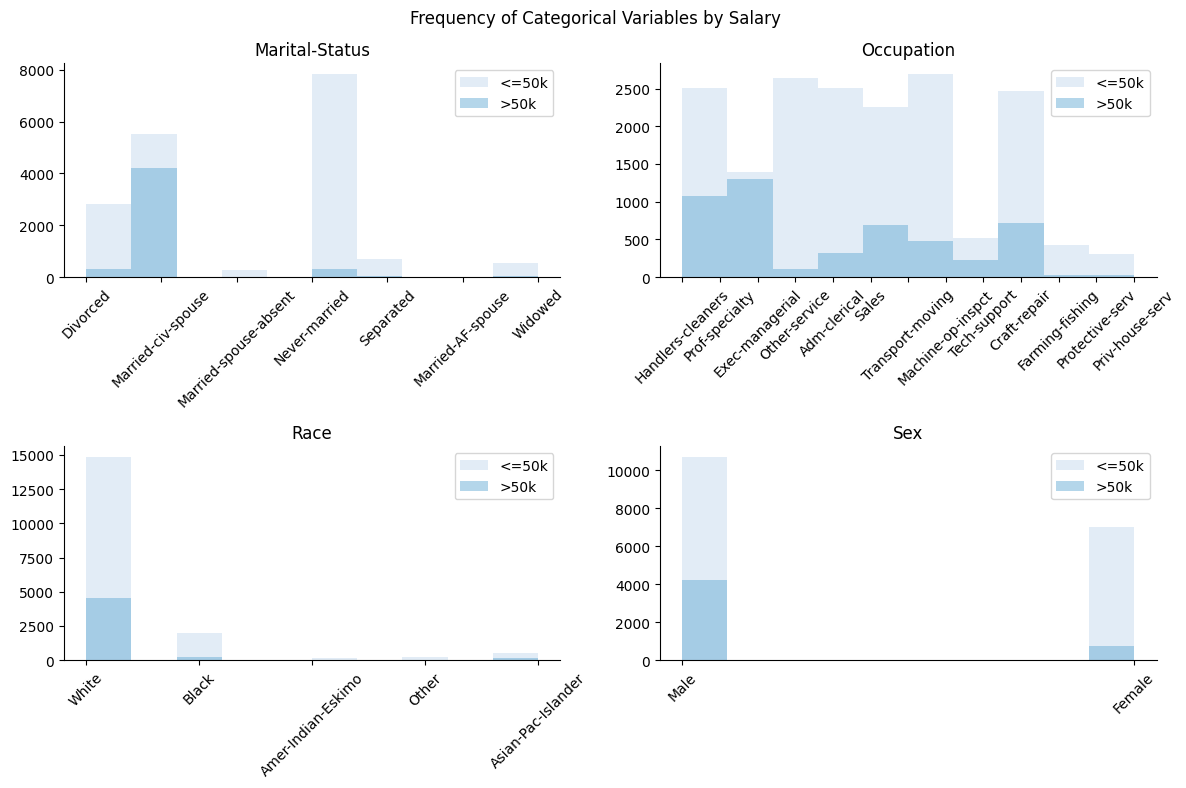

In [19]:
fig,ax = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(12,8))

for x,col in enumerate(private.columns):
    if private[col].dtype == object:
        ax[x//2-1][x%2].hist(negative[col], alpha=0.5, label='<=50k')
        ax[x//2-1][x%2].hist(positive[col], alpha=0.5, label='>50k')
        ax[x//2-1][x%2].set_xticklabels(ax[x//2-1][x%2].get_xticklabels(), rotation=45)
        ax[x//2-1][x%2].set_title(col)
        ax[x//2-1][x%2].legend(loc='upper right')

fig.suptitle('Frequency of Categorical Variables by Salary')
fig.tight_layout()
sns.despine()
plt.show()

Some of the occupations listed (it seems to be a very limited cross section of society) have a very high certainty of being in the >50k group. The other variables show seemingly strong indicators that can be used for prediction. (e.g. married, white, male)

### Outliers

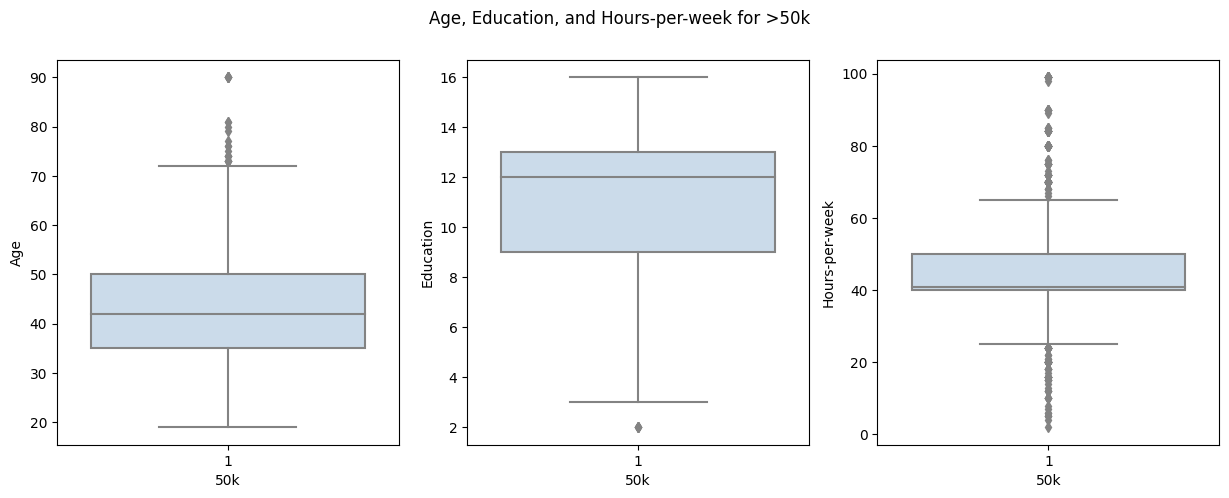

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x='50k', y='Age', data=positive, ax=ax[0])
sns.boxplot(x='50k', y='Education', data=positive, ax=ax[1])
sns.boxplot(x='50k', y='Hours-per-week', data=positive, ax=ax[2])
fig.suptitle('Age, Education, and Hours-per-week for >50k')
plt.show()

There are outliers in all three of the numeric variables. **Age** and **Hours** don't appear to have much predictive value and the criterion for **Education** seems to be a value greater than *9* (high-school graduate) so I don't feel the need to remove them from the data set.

### EDA Conclusion

Even though individually the numeric variables showed only weak correlation to the target variable, I anticipate that in combination with the categorical variables they will have   some predictive power.

## Models

The formula for patsy had an issue with some of the feature names, so I correct that here.

In [21]:
data.rename(columns={'50k': 'Salary'}, inplace=True)
data.rename(columns={'Hours-per-week': 'Hours'}, inplace=True)
data.rename(columns={'Marital-Status': 'Marital'}, inplace=True)

data.head()

,Age,Education,Marital,Occupation,Race,Sex,Hours,Salary
0,31,14,Never-married,Prof-specialty,White,Female,50,1
1,42,13,Married-civ-spouse,Exec-managerial,White,Male,40,1
2,37,10,Married-civ-spouse,Exec-managerial,Black,Male,80,1
3,40,11,Married-civ-spouse,Craft-repair,Asian-Pac-Islander,Male,40,1
4,40,16,Married-civ-spouse,Prof-specialty,White,Male,60,1


Since the number of features is low, I manually tested the various combinations to feed into patsy.

In [22]:
y, X = patsy.dmatrices("Salary ~ Marital", data=data)
lr = linear_model.LogisticRegressionCV(max_iter=5000)
lr_50k = lr.fit(X, y.ravel())

print(f'Prediction Accuracy: {lr_50k.score(X, y.ravel())}')

Prediction Accuracy: 0.7719506005751988


I tried every combination but it turns out, every feature contributes to the final accuracy score.

In [23]:
y, X = patsy.dmatrices("Salary ~ Marital+Education+Age+Hours+Occupation+Sex+Race", data=data)
lr = linear_model.LogisticRegressionCV(max_iter=5000)
lr_50k = lr.fit(X, y.ravel())

print(f'Prediction Accuracy: {lr_50k.score(X, y.ravel())}')

Prediction Accuracy: 0.81759995488637


Next, I split the data into training/testing sets.

In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.4, random_state = 42)

Finally, models are trained and tested. Logistic Regresssion, K-Neighbors, and Linear Discriminate Analysis were chosen.

In [25]:
lr = linear_model.LogisticRegressionCV(max_iter=5000)
lr_50k = lr.fit(X_train, y_train.ravel())
lr_50k_yhat = lr_50k.predict(X_test)

For KNN, various values were chosen for the number of neighbors, and *7* was the best with cross validation.

In [26]:
k = neighbors.KNeighborsClassifier(n_neighbors=7)
k_50k = k.fit(X_train, y_train.ravel())
k_50k_yhat = cross_val_predict(k_50k, X_test, y_test.ravel(), cv=18)

In [27]:
lda = LinearDiscriminantAnalysis()
lda_50k = lda.fit(X_train, y_train.ravel())
lda_50k_yhat = lda_50k.predict(X_test)

## Results and Analysis

To visualize the performance of each model, the function below will be called for each one.

In [28]:
def pretty_stats(y_test, y_hat, label):
    matrix = metrics.confusion_matrix(y_test, y_hat)
    text = metrics.classification_report(y_test.ravel(), y_hat, target_names=['<=50k', '>50k'])

    names = ["True Negative", "False Positive", "False Negative", "True Positive"]
    counts = [f"{x:0.0f}" for x in matrix.flatten()]
    percents = [f"{x:.2%}" for x in matrix.flatten() / np.sum(matrix)]
    labels = [f"{n}\n{c}\n{p}" for n, c, p in zip(names, counts, percents)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(4, 4))
    pretty_matrix = sns.heatmap(matrix, annot=labels, fmt="", vmin=500, vmax=6000, cmap='Blues')
    pretty_matrix.set(title=label)
    pretty_matrix.set(xlabel="Predicted", ylabel="Actual")
    plt.text(1, -0.5, text, size=8, ha="right", transform=plt.gca().transAxes)
    pretty_matrix.plot()

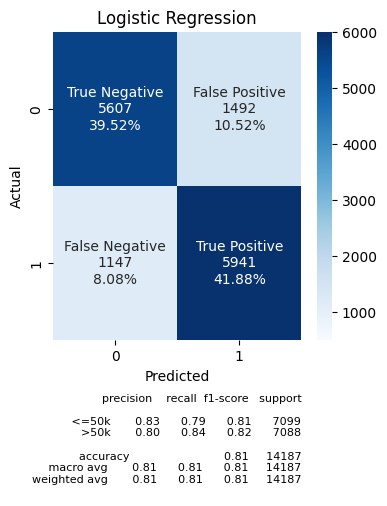

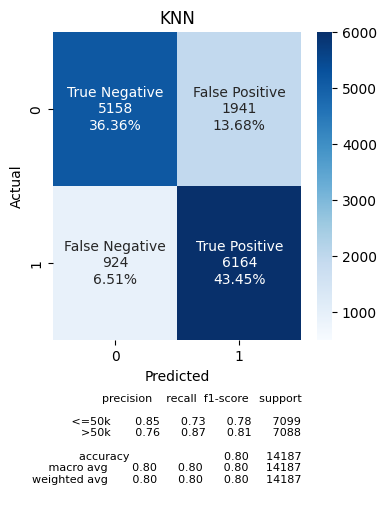

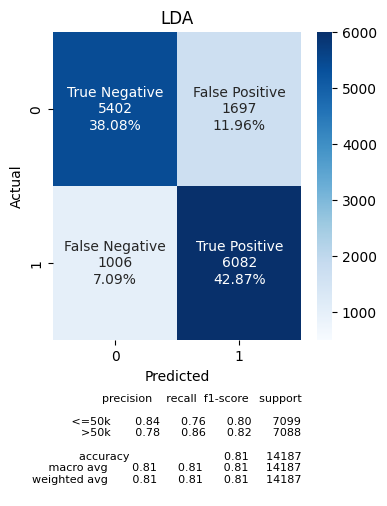

In [29]:
pretty_stats(y_test, lr_50k_yhat, 'Logistic Regression')
pretty_stats(y_test, k_50k_yhat, 'KNN')
pretty_stats(y_test, lda_50k_yhat, 'LDA')

Since the data set has been balanced, accuracy should be a good metric for choosing the best model. Logistic Regression and LDA had the highest and same accuracy. To break the tie, F1 score was used. Logistic Regression ended up with a better balance of precision and recall.

Our chosen model has an overall accuracy of 0.81.

## Models Revisited

Since the above methods weren't the most accurate, I wanted to see if some of the more advanced classifiers could do better. Below, I try Naive Bayes, Decision Tree, AdaBoost, and Multi-layer Perceptron.

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

In [35]:
bayes = GaussianNB()
bayes_50k = bayes.fit(X_train, y_train.ravel())
bayes_50k_yhat = bayes_50k.predict(X_test)

For the decision tree, the parameters for the maximum depth and minimum samples per leaf were adjusted but weren't an improvment on the defaults.

In [36]:
dtree = DecisionTreeClassifier()
dtree_50k = dtree.fit(X_train, y_train.ravel())
dtree_50k_yhat = dtree_50k.predict(X_test)

In [37]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=5000)
mlp_50k = mlp.fit(X_train, y_train.ravel())
mlp_50k_yhat = mlp_50k.predict(X_test)

In [38]:
ada = AdaBoostClassifier(n_estimators=100)
ada_50k = ada.fit(X_train, y_train.ravel())
ada_50k_yhat = ada_50k.predict(X_test)

## Results

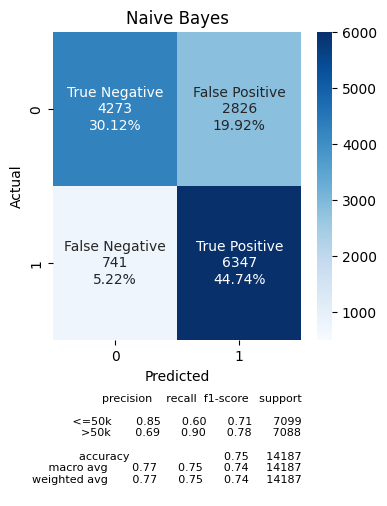

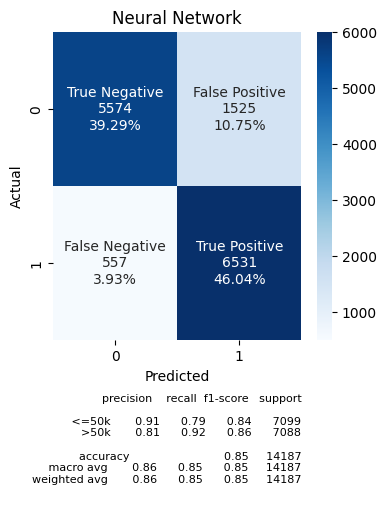

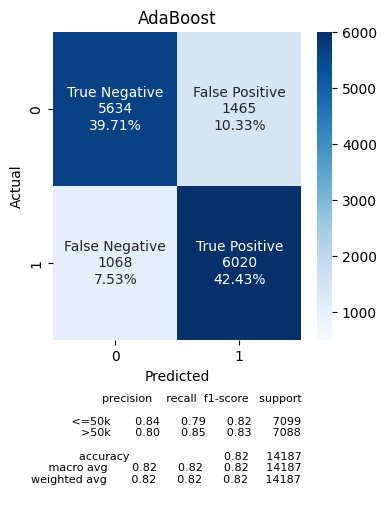

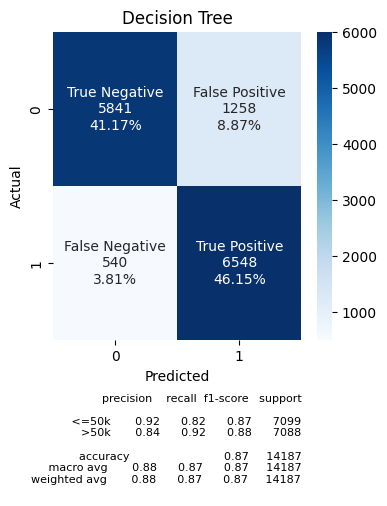

In [39]:
pretty_stats(y_test, bayes_50k_yhat, 'Naive Bayes')
pretty_stats(y_test, mlp_50k_yhat, 'Neural Network')
pretty_stats(y_test, ada_50k_yhat, 'AdaBoost')
pretty_stats(y_test, dtree_50k_yhat, 'Decision Tree')

The decision tree classifier was the best with an accuracy of 0.87. This is a decent improvement over the Logistic Regression.

## Discussion and Conclusion

I was expecting a classification problem to be an easier task than a linear regression problem. This turns out not to be necessarily true because it is harder to evaluate the model. For a linear regression, it is easy to extract the parameters and graph the data.

I was a little disappointed with the accuracy of the methods applied. There was some improvement with the more advanced methods, but the fact that the improvement wasn't more substancial leads me to believe that the issue is probably with the quality of the data. I think in the future, I should be much more picky with the quality of the data set if possible.